In [1]:
import numpy as np
import cvxpy as cp
from itertools import chain
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf

root = os.path.abspath("..")
sys.path.append(root)

from config import Config
from common.constants import IMAGE_SHAPE_WITHOUT_CHANNELS, MODALITY_SET
from plant_clef_meta import *

In [2]:
CONFIG = Config(os.path.join(root, "config.json"))
ORGANS = MODALITY_SET

# Load and cache metadata

In [3]:
meta = PlantClefImage.load(CONFIG, from_cache=True)
meta = [img for img in meta if img.content in ORGANS]

PlantClefImage.save(CONFIG, meta, pretty=True)

len(meta)

67812

# Collect observations per class

Collect observations (individual plant specimens) in the form of dictionaries with keys representing plant organs and values – arrays with corresponding organ images of a specific observation. Group them by classes using a dictionary with keys – classes and values – arrays with observations.

In [4]:
class_observations = dict()

for image in meta:
    if image.class_id not in class_observations:
        class_observations[image.class_id] = {}
    
    observations = class_observations[image.class_id]

    if image.observation_id not in observations:
        observations[image.observation_id] = {o: [] for o in ORGANS}

    observation = observations[image.observation_id]
    observation[image.content].append(image)

len(class_observations)

999

# Filter unsplitable organ images and classes

Remove specific organ images (e.g., images of a flower) from classes if their total count is less than 3 (i.e., the number of data splits). Then, remove such observations that lost all their images due to the this procedure. Finally, remove all classes that have less than 3 observations, as we will split data observation-wise.

In [5]:
for cls, observations in class_observations.items():
    updated_observations = {}

    total_organ_counts = {
        organ: sum(1 if observation[organ] else 0 for observation in observations.values())
        for organ in ORGANS
    }

    for organ, count in total_organ_counts.items():
        if count < 3:
            for id, observation in observations.items():
                updated_observation = updated_observations[id] if id in updated_observations else observation.copy()
                updated_observation[organ] = []
                updated_observations[id] = updated_observation

    for id, updated_observation in updated_observations.items():
        has_values = False
        for values in updated_observation.values():
            if len(values) > 0:
                observations[id] = updated_observation
                has_values = True
                break
        if not has_values:
            observations.pop(id)

class_observations = {cls: observations for cls, observations in class_observations.items() if len(observations) >= 3}

len(class_observations)

979

# Split the data

To avoid potential bias, we want to split the data observation-wise, i.e., images of the same observation must occurr only in one of the data splits (train, validation or test). This makes splitting non-trivial, as each observation has a different number of each organ images, and we have two contradictory objectives: (1) we want to ensure a certain proportion (60%:20%:20%) of observations in each data split to maximize the diversity of data in each of them, and (2) we want to ensure a certain proportion of each plant organ images in each split (60%:20%:20%) because ultimately it is the data that we will use train, validate and evaluate our models, and we want splits with certain sizes. Finally, as we want our splits stratified, we need to satisfy these objectives for each class separately.

So, we frame this as a constrained optimization problem that we solve for each class separately:

##### $ \textrm{minimize} \sum_{s\in S}(||\mathbf{x}_s||_1 - \lambda_sN)^2+\sum_{o\in O}\sum_{s\in S}(\mathbf{c}_o^T\mathbf{x}_s-\lambda_s||\mathbf{c}_o||_1)^2 $
##### $ \textrm{subject to } \sum_{s\in S} \mathbf{x}_s=\mathbf{1} $

where: \
$N$ is the number of observations \
$S$ is a set of data splits \
$O$ is a set of organ types \
$c_o\in\mathbb{N}^N$ is a vector with counts of organ $o$ images for each observation \
$x_s\in\{0,1\}^N$ is a decision vector for the split $s$ in which an element $1$ denote that a specific observation belongs to the split $s$ \
$\lambda_s\in [0, 1]$ is a proportion for the split $s$.

In [6]:
train_fraction = 0.6
valid_fraction = 0.2
test_fraction = 0.2

verbose = False

train_class_organs = dict()
valid_class_organs = dict()
test_class_organs = dict()

for cls, observations in class_observations.items():
    organs = {o: [] for o in ORGANS}
    observation_list = list(observations.values())

    for organ in ORGANS:
        for observation in observation_list:
            count = len(observation[organ]) if organ in observation else 0
            organs[organ].append(count)

    organs = {k: np.expand_dims(v, axis=1) for k, v in organs.items()}
    organ_counts = {k: sum(v) for k, v in organs.items()}

    var_count = len(observation_list)

    var_train = cp.Variable(var_count, boolean=True)
    var_valid = cp.Variable(var_count, boolean=True)
    var_test = cp.Variable(var_count, boolean=True)
    
    def build_objective(fraction, vars):
        observation_objective = cp.square(cp.sum(vars) - fraction * var_count)
        organ_objective = cp.sum([
            cp.square(values.T @ vars - fraction * organ_counts[organ])
            for organ, values in organs.items()
        ])
        return observation_objective + organ_objective
    
    objective = cp.Minimize(
        build_objective(train_fraction, var_train)
        + build_objective(valid_fraction, var_valid)
        + build_objective(test_fraction, var_test)
    )

    constraints = [var_train + var_valid + var_test == 1]

    problem = cp.Problem(objective, constraints)
    problem.solve(
        solver=cp.SCIP, 
        scip_params={'limits/time': 1},
    )

    val_train = np.rint(var_train.value).astype(np.uint8)
    val_valid = np.rint(var_valid.value).astype(np.uint8)
    val_test = np.rint(var_test.value).astype(np.uint8)

    if verbose:
        print(f"CLASS {cls} splits[train:validation:test]" + "=" * 20 + "\n")
        print(f"Observations: {val_train.sum()}:{val_valid.sum()}:{val_test.sum()} | {val_train.sum() / var_count}:{val_valid.sum() / var_count}:{val_test.sum() / var_count}")

        for organ, values in organs.items():
            count = organ_counts[organ]

            train_organs = values.T @ val_train
            valid_organs = values.T @ val_valid
            test_organs = values.T @ val_test

            print(f"{organ}: {train_organs}:{valid_organs}:{test_organs} | {train_organs / count}:{valid_organs / count}:{test_organs / count}")

    def prepare_split(values):
        split = {organ: [] for organ in ORGANS}

        for idx in np.flatnonzero(values):
            for organ in ORGANS:
                split[organ].extend(observation_list[idx][organ])

        return split
    
    train_class_organs[cls] = prepare_split(val_train)
    valid_class_organs[cls] = prepare_split(val_valid)
    test_class_organs[cls] = prepare_split(val_test)

/Users/alfredlapkovsky/Documents/Projects/THESIS/Code/venv/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# Fix empty splits

In some classes there may be a very small number of a specific organ images. In such case, some split could be unassigned images, so we need to manually fix it and give it an image from another split.

In [7]:
for cls in class_observations.keys():
    for organ in ORGANS:
        split_organs = [
            train_class_organs[cls][organ],
            valid_class_organs[cls][organ],
            test_class_organs[cls][organ],
        ]

        def sort(organs):
            return sorted(organs, key=lambda x: len(x), reverse=True)

        split_organs = sort(split_organs)

        fixes = 0

        if len(split_organs[0]) == 0:
            continue
        if len(split_organs[1]) == 0:
            random_idx = np.random.choice(range(len(split_organs[0])))
            random_organ = split_organs[0].pop(random_idx)
            split_organs[1].append(random_organ)
            split_organs = sort(split_organs)
            fixes += 1
        if len(split_organs[2]) == 0:
            random_idx = np.random.choice(range(len(split_organs[0])))
            random_organ = split_organs[0].pop(random_idx)
            split_organs[2].append(random_organ)
            fixes += 1

        if fixes > 0:
            print(f"CLASS {cls}: {fixes} fixes")

        counts = [len(x) for x in split_organs]
        assert all(counts), f"{counts=}"

        media_ids = set()
        for organs in split_organs:
            ids = set([o.media_id for o in organs])
            assert len(ids.intersection(media_ids)) == 0
            media_ids.update(ids)

CLASS 973: 1 fixes
CLASS 9954: 1 fixes
CLASS 4455: 1 fixes
CLASS 8544: 1 fixes
CLASS 1395: 1 fixes
CLASS 30090: 1 fixes
CLASS 8622: 1 fixes
CLASS 8622: 1 fixes
CLASS 2910: 1 fixes
CLASS 6569: 1 fixes
CLASS 1765: 1 fixes
CLASS 1765: 1 fixes
CLASS 30460: 1 fixes
CLASS 1066: 1 fixes
CLASS 622: 1 fixes
CLASS 4039: 1 fixes
CLASS 30163: 1 fixes
CLASS 30163: 1 fixes
CLASS 14930: 1 fixes
CLASS 30378: 1 fixes
CLASS 3987: 1 fixes
CLASS 1966: 1 fixes
CLASS 30089: 1 fixes
CLASS 383: 1 fixes
CLASS 3505: 1 fixes
CLASS 576: 1 fixes
CLASS 4262: 1 fixes
CLASS 3831: 1 fixes
CLASS 30008: 1 fixes
CLASS 30315: 1 fixes
CLASS 6376: 1 fixes
CLASS 166: 1 fixes
CLASS 1360: 1 fixes
CLASS 459: 1 fixes
CLASS 1939: 1 fixes
CLASS 6302: 1 fixes
CLASS 8532: 1 fixes
CLASS 178: 1 fixes
CLASS 5307: 1 fixes
CLASS 59: 1 fixes
CLASS 12: 1 fixes
CLASS 2905: 1 fixes
CLASS 2905: 1 fixes
CLASS 1315: 1 fixes
CLASS 30402: 1 fixes
CLASS 3452: 1 fixes
CLASS 671: 1 fixes
CLASS 5834: 1 fixes
CLASS 30018: 1 fixes
CLASS 14807: 1 fixes


# Map labels to $[0, N]$

Original labels are represented by impractical large numbers, so we map them to the interval [0, number of labels].

In [8]:
def get_class_distribution(meta, included_labels):
    classes = {}

    for img in meta:
        cls = img.class_id
        if cls in included_labels:
            classes[cls] = (classes[cls] + 1) if cls in classes else 1
    
    return np.array(sorted(classes.items(), key=lambda i: i[1], reverse=True))

class_dist = get_class_distribution(meta, set(class_observations.keys()))
class_map = {c: i for i, c in enumerate(class_dist[:, 0])}

mapped_train_class_organs = {class_map[cls]: organs for cls, organs in train_class_organs.items()}
mapped_valid_class_organs = {class_map[cls]: organs for cls, organs in valid_class_organs.items()}
mapped_test_class_organs = {class_map[cls]: organs for cls, organs in test_class_organs.items()}

len(class_map)

979

# Plot the resulted splits

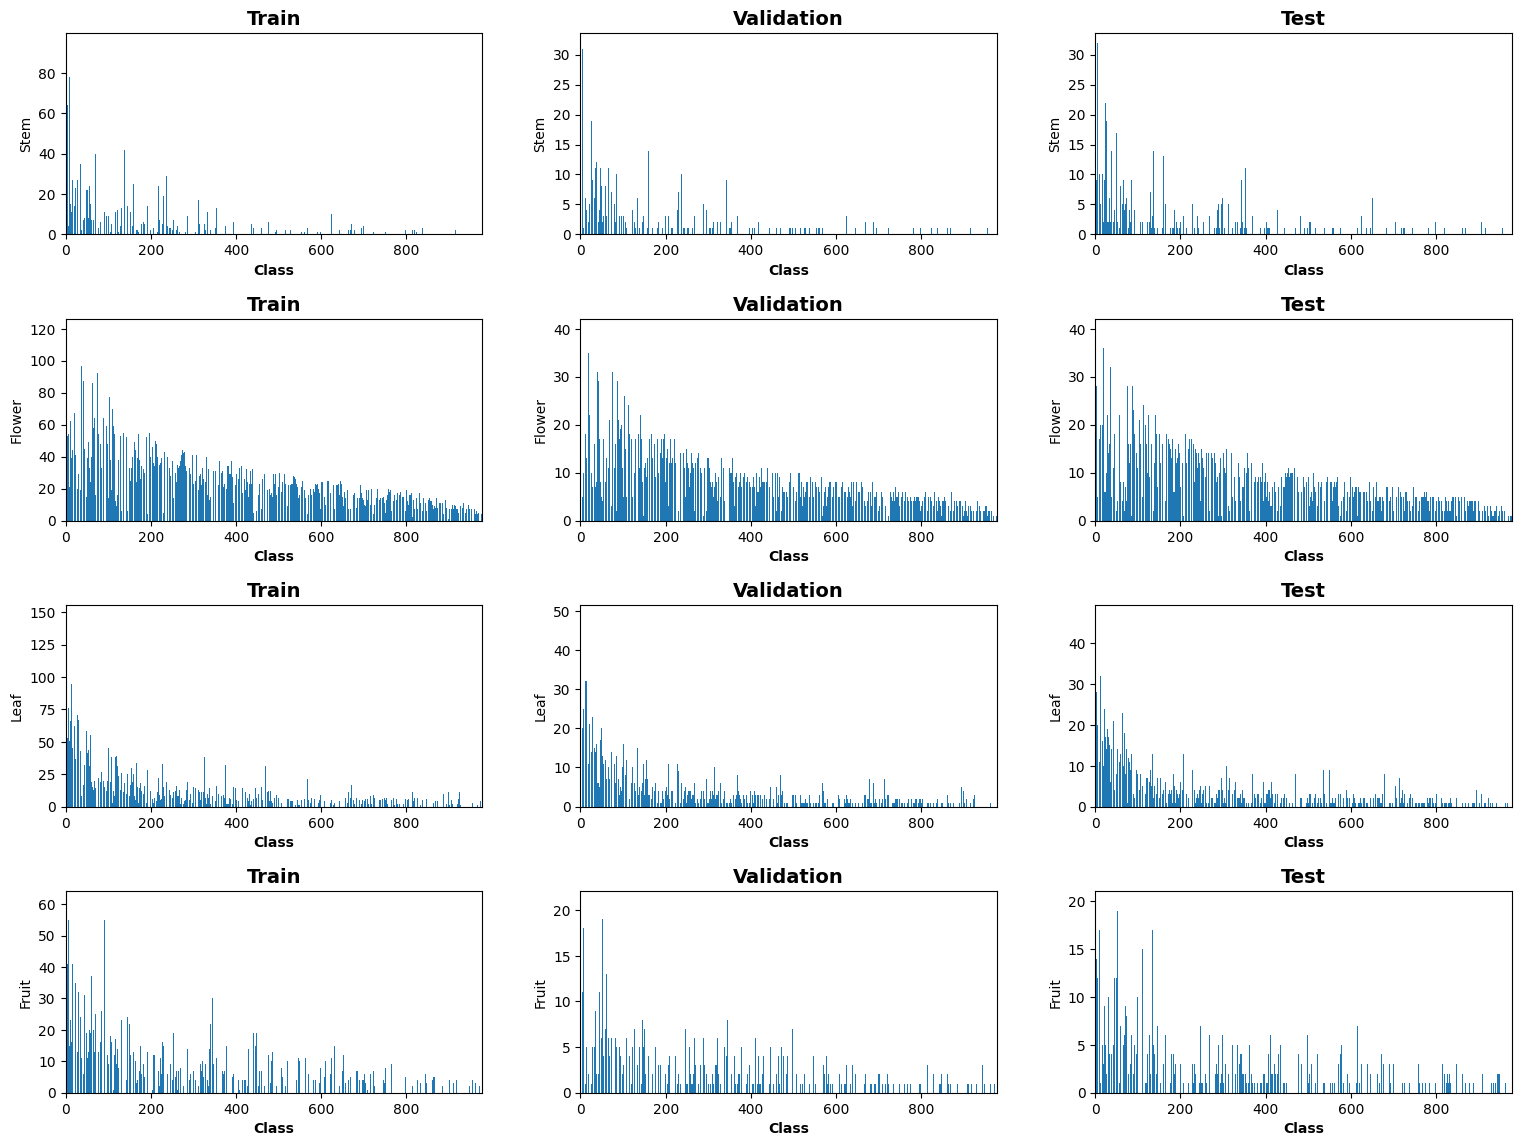

In [19]:
fig, ax = plt.subplots(4, 3)

fig.set_size_inches((16, 12))
fig.tight_layout(pad=4)

for organ_idx, organ in enumerate(ORGANS):
    classes = range(len(class_map))

    def plot(col, split_name, class_organs):
        ax[organ_idx][col].bar(classes, [len(class_organs[cls][organ]) for cls in classes])
        ax[organ_idx][col].set_xlabel("Class", fontdict={"weight": "semibold"})
        ax[organ_idx][col].set_ylabel(organ)
        ax[organ_idx][col].set_title(split_name, fontdict={"weight": "bold", "size": 14})
        ax[organ_idx][col].set_xlim([0, len(classes) - 1])

    plot(0, "Train", mapped_train_class_organs)
    plot(1, "Validation", mapped_valid_class_organs)
    plot(2, "Test", mapped_test_class_organs)

def save_plot(name):
    if not os.path.exists("images"):
        os.mkdir("images")
    plt.savefig(os.path.join("images", name))

save_plot("splits.pdf")

# Count split sizes

In [10]:
def count_entities(class_organs):
    observation_ids = set()

    for organs_dict in class_organs.values():
        for organs in organs_dict.values():
            for organ in organs:
                observation_ids.add(organ.observation_id)

    return {
        "Observations": len(observation_ids),
        **{
            o: sum(len(organs[o]) for organs in class_organs.values())
            for o in ORGANS
        }
    }

train_counts = count_entities(mapped_train_class_organs)
valid_counts = count_entities(mapped_valid_class_organs)
test_counts = count_entities(mapped_test_class_organs)

for key in train_counts.keys():
    train_count =  train_counts[key]
    valid_count = valid_counts[key]
    test_count = test_counts[key]
    total_count = train_count + valid_count + test_count

    print(f"{key}: train {train_count} ({train_count / total_count}), validation {valid_count} ({valid_count / total_count}), test {test_count} ({test_count / total_count})")

Observations: train 16737 (0.592145763311516), validation 5788 (0.20477622501326728), test 5740 (0.2030780116752167)
Stem: train 3196 (0.590539541759054), validation 1119 (0.20676274944567627), test 1097 (0.20269770879526977)
Flower: train 21859 (0.6009347079037801), validation 7273 (0.1999450171821306), test 7243 (0.19912027491408935)
Leaf: train 9357 (0.5984267075978511), validation 3172 (0.20286518291123048), test 3107 (0.19870810949091838)
Fruit: train 5096 (0.5996705107084019), validation 1678 (0.19745822546481526), test 1724 (0.20287126382678278)


# Save unimodal datasets

Save shuffled data splits in TFRecord format for each modality to use for training unimodal models

In [11]:
def save_unimodal_data(organ, split_class_organs, split_name):
    instances = list(chain(*[organs[organ] for organs in split_class_organs.values()]))
    np.random.shuffle(instances)

    file_path = CONFIG.get_unimodal_file_path(split_name, organ)
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with tf.io.TFRecordWriter(file_path) as writer:
        for i, instance in enumerate(instances):
            path = instance.get_image_file_path(CONFIG)

            image = tf.io.read_file(path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, IMAGE_SHAPE_WITHOUT_CHANNELS)
            image = tf.cast(image, dtype=tf.uint8)
            image = tf.io.encode_jpeg(image)
            image = image.numpy()
            
            label = class_map[instance.class_id]

            writer.write(tf.train.Example(
                features=tf.train.Features(
                    feature={
                        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
                    },
                )
            ).SerializeToString())

            print(f"\r[{organ}, {split_name}] Finished {i + 1}/{len(instances)}", end="")
    print()

for organ in ORGANS:
    save_unimodal_data(organ, mapped_train_class_organs, "train")
    save_unimodal_data(organ, mapped_valid_class_organs, "validation")
    save_unimodal_data(organ, mapped_test_class_organs, "test")
        

[Stem, train] Finished 21/3196

2024-10-19 13:24:32.292722: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-10-19 13:24:32.292744: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-19 13:24:32.292750: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-19 13:24:32.292780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-19 13:24:32.292794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[Stem, train] Finished 3196/3196
[Stem, validation] Finished 1119/1119
[Stem, test] Finished 1097/1097
[Flower, train] Finished 21859/21859
[Flower, validation] Finished 7273/7273
[Flower, test] Finished 7243/7243
[Leaf, train] Finished 9357/9357
[Leaf, validation] Finished 3172/3172
[Leaf, test] Finished 3107/3107
[Fruit, train] Finished 5096/5096
[Fruit, validation] Finished 1678/1678
[Fruit, test] Finished 1724/1724


# Save multimodal datasets

Generate random combinations of images of different plant organs and save those as TFRecord datasets for each data split.

In [12]:
def generate_multimodal_combinations(split_class_organs, split_name):
    file_path = CONFIG.get_multimodal_file_path(split_name)
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    combinations = []

    for label, class_organs in split_class_organs.items():
        organ_values = [(o, v) for o, v in class_organs.items() if len(v) > 0]
        sorted_organ_values = sorted(organ_values, key=lambda x: len(x[1]), reverse=True)
        assert sorted_organ_values

        n_combinations = len(sorted_organ_values[0][1])
        assert n_combinations > 0

        organ_names = [x[0] for x in sorted_organ_values]
        organ_values = [x[1] for x in sorted_organ_values]

        organ_values = [np.random.permutation(values) for values in organ_values]
        organ_values = [np.resize(values, n_combinations) for values in organ_values]
        organ_values = [iter(values) for values in organ_values]

        organ_names_values = dict(zip(organ_names, organ_values))

        for _ in range(n_combinations):
            combination = {
                "label": label,
            }

            for organ in ORGANS:
                if organ in organ_names_values:
                    value = next(organ_names_values[organ])
                    combination[organ] = value

            combinations.append(combination)

    with tf.io.TFRecordWriter(file_path) as writer:
        np.random.shuffle(combinations)
        
        for i, combination in enumerate(combinations):
            label = combination["label"]
            features = {
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }

            for organ in ORGANS:
                if organ in combination:
                    value = combination[organ]

                    path = value.get_image_file_path(CONFIG)
            
                    image = tf.io.read_file(path)
                    image = tf.image.decode_image(image, channels=3)
                    image = tf.image.resize(image, IMAGE_SHAPE_WITHOUT_CHANNELS)
                    image = tf.cast(image, dtype=tf.uint8)
                    image = tf.io.encode_jpeg(image)
                    image = image.numpy()

                    features[organ] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image]))
            
            writer.write(tf.train.Example(
                features=tf.train.Features(
                    feature=features,
                )
            ).SerializeToString())

            print(f"\r[{split_name}] Finished {i + 1}/{len(combinations)}", end="")
        print()

generate_multimodal_combinations(mapped_train_class_organs, "train")
generate_multimodal_combinations(mapped_valid_class_organs, "validation")
generate_multimodal_combinations(mapped_test_class_organs, "test")

[train] Finished 25661/25661
[validation] Finished 8552/8552
[test] Finished 8500/8500


# Save unimodal labels

Additionally, save labels of unimodal datasets separately, for convenience.

In [13]:
def save_unimodal_labels(organ, split_name):
    def parse(proto):
        return tf.io.parse_single_example(proto, {
            "label": tf.io.FixedLenFeature([], tf.int64)
        })["label"]

    src_path = CONFIG.get_unimodal_file_path(split_name, organ)
    dataset = tf.data.TFRecordDataset(src_path).map(parse, num_parallel_calls=tf.data.AUTOTUNE)

    dst_path = CONFIG.get_unimodal_labels_file_path(split_name, organ)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    with open(dst_path, "w") as f:
        for label in dataset:
            f.write(f"{label}\n")

for organ in ORGANS:
    save_unimodal_labels(organ, "train")
    save_unimodal_labels(organ, "validation")
    save_unimodal_labels(organ, "test")

# Save multimodal labels

Additionally, save labels of multimodal datasets separately, for convenience.

In [14]:
def save_multimodal_labels(split_name):
    def parse(proto):
        return tf.io.parse_single_example(proto, {
            "label": tf.io.FixedLenFeature([], tf.int64)
        })["label"]
    
    src_path = CONFIG.get_multimodal_file_path(split_name)
    dataset = tf.data.TFRecordDataset(src_path).map(parse, num_parallel_calls=tf.data.AUTOTUNE)

    dst_path = CONFIG.get_multimodal_labels_file_path(split_name)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    with open(dst_path, "w") as f:
        for label in dataset:
            f.write(f"{label}\n")

save_multimodal_labels("train")
save_multimodal_labels("validation")
save_multimodal_labels("test")